<h1 align="center">Projet IA HumanForYou</h1>

In [325]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
import tarfile
import os

# Configuring display settings
plt.rcParams['figure.figsize'] = (12, 5)
sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format) 
warnings.filterwarnings("ignore", category=FutureWarning)

In [326]:
general_df = pd.read_csv("Data_cleaned/general_data.csv")
manager_srv_df = pd.read_csv("Data_cleaned/manager_survey_data.csv")
employee_srv_df = pd.read_csv("Data_cleaned/employee_survey_data.csv")
horaires_df = pd.read_csv("Data_cleaned/features_horaires_travail.csv")

In [327]:
# Fusion general + manager survey
merged_df = pd.merge(general_df, manager_srv_df, on='EmployeeID', how='left')

# Fusion avec employee survey
merged_df = pd.merge(merged_df, employee_srv_df, on='EmployeeID', how='left')

# Fusion avec les horaires agrégés
merged_df = pd.merge(merged_df, horaires_df, on='EmployeeID', how='left')


In [328]:
constant_cols = [col for col in merged_df.columns if merged_df[col].nunique(dropna=False) == 1]
constant_cols

['EmployeeCount', 'Over18', 'StandardHours']

In [329]:
merged_df.drop(['Over18', 'StandardHours', 'EmployeeCount'], axis=1, inplace=True)

In [330]:
merged_df.to_csv("Data_cleaned/all_data.csv", index=False)

<h1>EDA</h1>

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [332]:
#Lecture du CSV
merged_df = pd.read_csv("Data_cleaned/all_data.csv")

#Aperçu des données
merged_df.head()

#Informations générale
merged_df.info()

#Statistiques descriptives
merged_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       4410 non-null   int64  
 1   Attrition                 4410 non-null   object 
 2   BusinessTravel            4410 non-null   object 
 3   Department                4410 non-null   object 
 4   DistanceFromHome          4410 non-null   int64  
 5   Education                 4410 non-null   int64  
 6   EducationField            4410 non-null   object 
 7   EmployeeID                4410 non-null   int64  
 8   Gender                    4410 non-null   object 
 9   JobLevel                  4410 non-null   int64  
 10  JobRole                   4410 non-null   object 
 11  MaritalStatus             4410 non-null   object 
 12  MonthlyIncome             4410 non-null   int64  
 13  NumCompaniesWorked        4410 non-null   float64
 14  PercentS

,Age,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,taux_absence,heures_moy_par_jour,total_heures_travaillees
count,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00,4410.00
mean,36.92,9.19,2.91,2205.50,2.06,65029.31,2.69,15.21,0.79,11.28,2.80,7.01,2.19,4.12,2.73,3.15,2.73,2.73,2.76,9.48,7.70,1821.28
std,9.13,8.11,1.02,1273.20,1.11,47068.89,2.49,3.66,0.85,7.77,1.29,6.13,3.22,3.57,0.71,0.36,1.09,1.10,0.70,2.11,1.34,331.36
min,18.00,1.00,1.00,1.00,1.00,10090.00,0.00,11.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,1.00,1.00,1.00,4.98,5.95,1348.80
25%,30.00,2.00,2.00,1103.25,1.00,29110.00,1.00,12.00,0.00,6.00,2.00,3.00,0.00,2.00,2.00,3.00,2.00,2.00,2.00,7.66,6.67,1563.57
50%,36.00,7.00,3.00,2205.50,2.00,49190.00,2.00,14.00,1.00,10.00,3.00,5.00,1.00,3.00,3.00,3.00,3.00,3.00,3.00,9.58,7.41,1745.78
75%,43.00,14.00,4.00,3307.75,3.00,83800.00,4.00,18.00,1.00,15.00,3.00,9.00,3.00,7.00,3.00,3.00,4.00,4.00,3.00,11.11,8.37,1967.30
max,60.00,29.00,5.00,4410.00,5.00,199990.00,9.00,25.00,3.00,40.00,6.00,40.00,15.00,17.00,4.00,4.00,4.00,4.00,4.00,13.79,11.03,2723.38


In [333]:
#Nombre de valeurs manquantes
missing = merged_df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing


Series([], dtype: int64)

In [334]:
#Pourcentage de valeurs manquantes
missing_pct = (missing / len(merged_df)) * 100
missing_pct


Series([], dtype: float64)

In [335]:
#Identifier et séparer les types de variables (numériques et catégorielles)
num_cols = merged_df.select_dtypes(include=["int64", "float64"]).columns.drop(['EmployeeID'])
cat_cols = merged_df.select_dtypes(include=["object"]).columns.drop(['Attrition'])




### Encodages des variables catégorielles et Normalisation des variables numériques

In [336]:
#Encodage variables catégorielles
encoder = OneHotEncoder()
cat_encoded = pd.DataFrame(encoder.fit_transform(merged_df[cat_cols]).toarray(), columns=encoder.get_feature_names_out(cat_cols))

cat_encoded.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
2,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
3,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00


In [337]:

#Normalisation variables numériques
scaler = StandardScaler()
num_scaled = pd.DataFrame(scaler.fit_transform(merged_df[num_cols]), columns=num_cols)

num_scaled.head()

,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,taux_absence,heures_moy_par_jour,total_heures_travaillees
0,1.54,-0.39,-0.89,-0.96,1.41,-0.68,-1.15,-0.93,-1.32,2.48,-0.98,-0.68,-1.16,0.38,-0.43,0.25,1.16,-1.09,0.77,-0.25,-0.33
1,-0.65,0.10,-1.87,-0.96,-0.49,-1.08,2.13,0.24,-0.68,0.16,-0.33,-0.37,-0.03,-1.03,2.35,0.25,-0.66,1.76,0.05,0.01,0.00
2,-0.54,0.96,1.06,1.75,2.73,-0.68,-0.06,2.59,-0.81,-0.62,-0.33,-0.68,-0.31,0.38,-0.43,-0.67,-0.66,-2.51,-1.04,-0.52,-0.37
3,0.12,-0.89,2.04,0.85,0.39,0.12,-1.15,2.59,0.22,1.71,0.16,1.49,0.25,-1.03,-0.43,1.17,1.16,0.34,0.23,-0.38,-0.39
4,-0.54,0.10,-1.87,-0.96,-0.88,0.52,-0.88,1.42,-0.29,-0.62,-0.16,-0.68,-0.03,0.38,-0.43,1.17,-1.57,0.34,-1.59,0.23,0.42


### Séparation des caractéristiques (X) et de la cible (y)

In [338]:
#Séparation des caractéristiques et de la cible
X = pd.concat([cat_encoded, num_scaled], axis=1)
y = merged_df['Attrition']

#Vérification des dimensions
print(X.shape)
print(y.shape)

(4410, 47)
(4410,)


### Visualisation des variables Numériques

<function matplotlib.pyplot.show(close=None, block=None)>

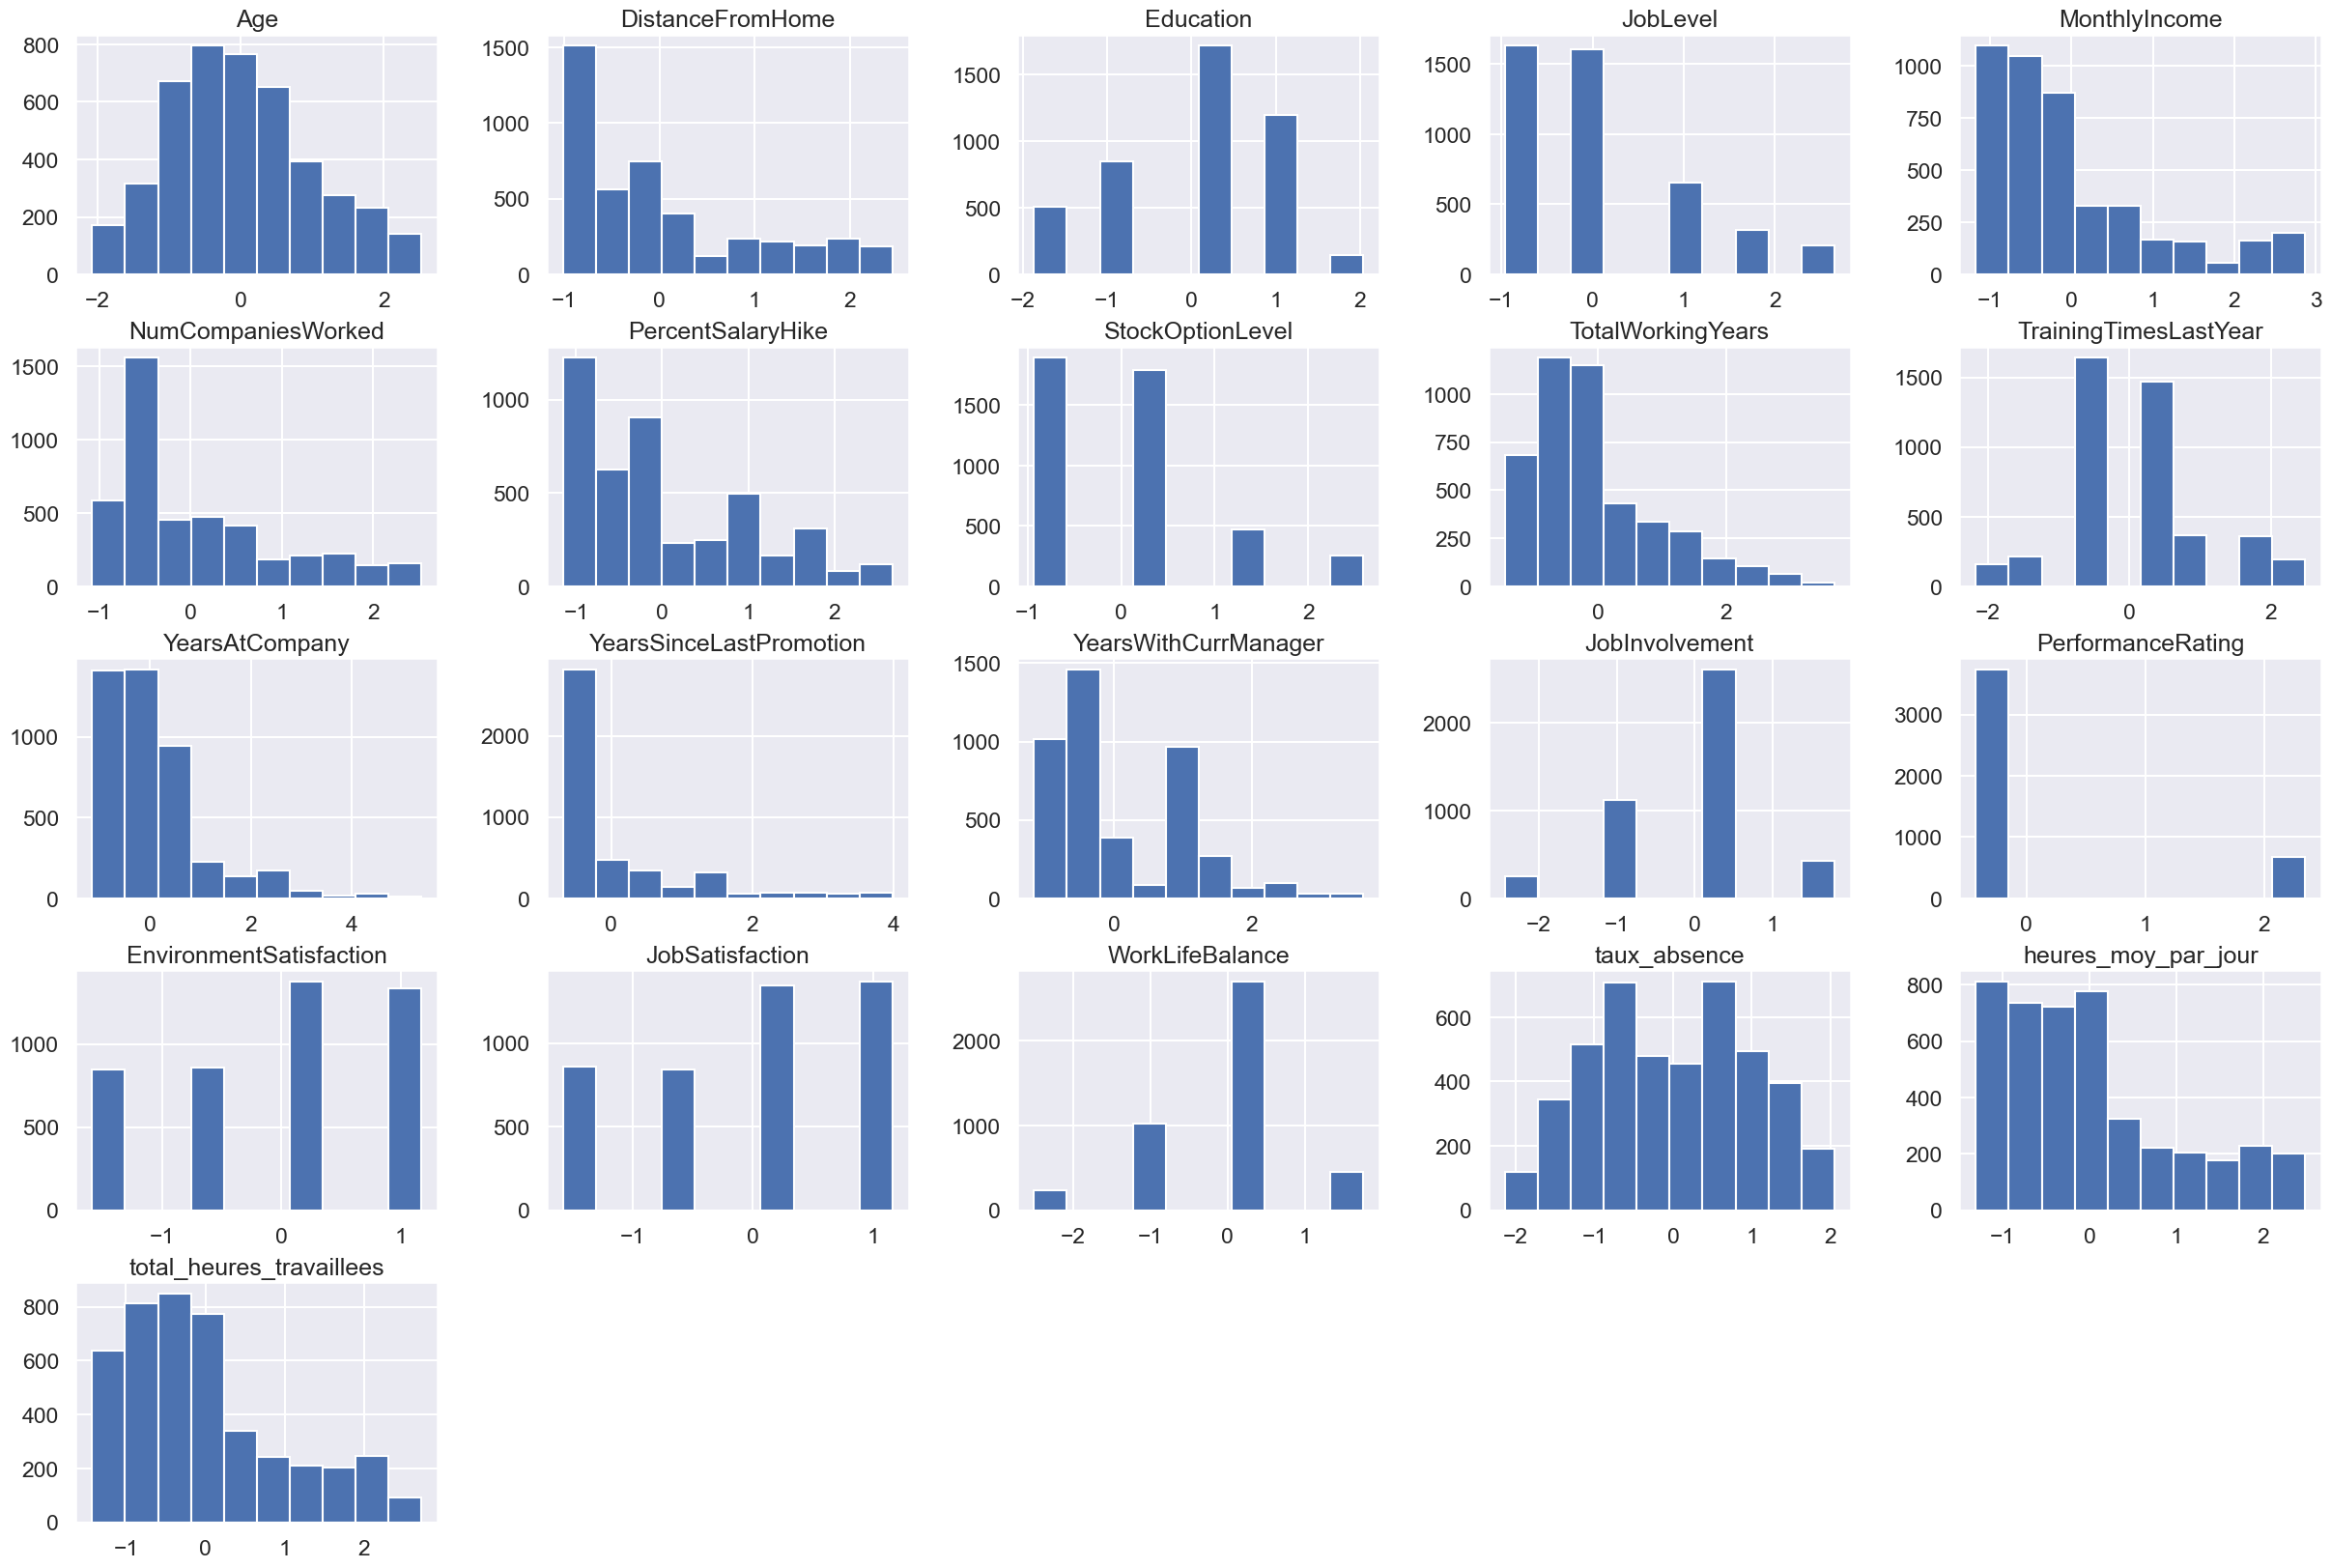

In [339]:
num_scaled.hist(figsize=(30, 20))
plt.show

### Matrice de corrélation 

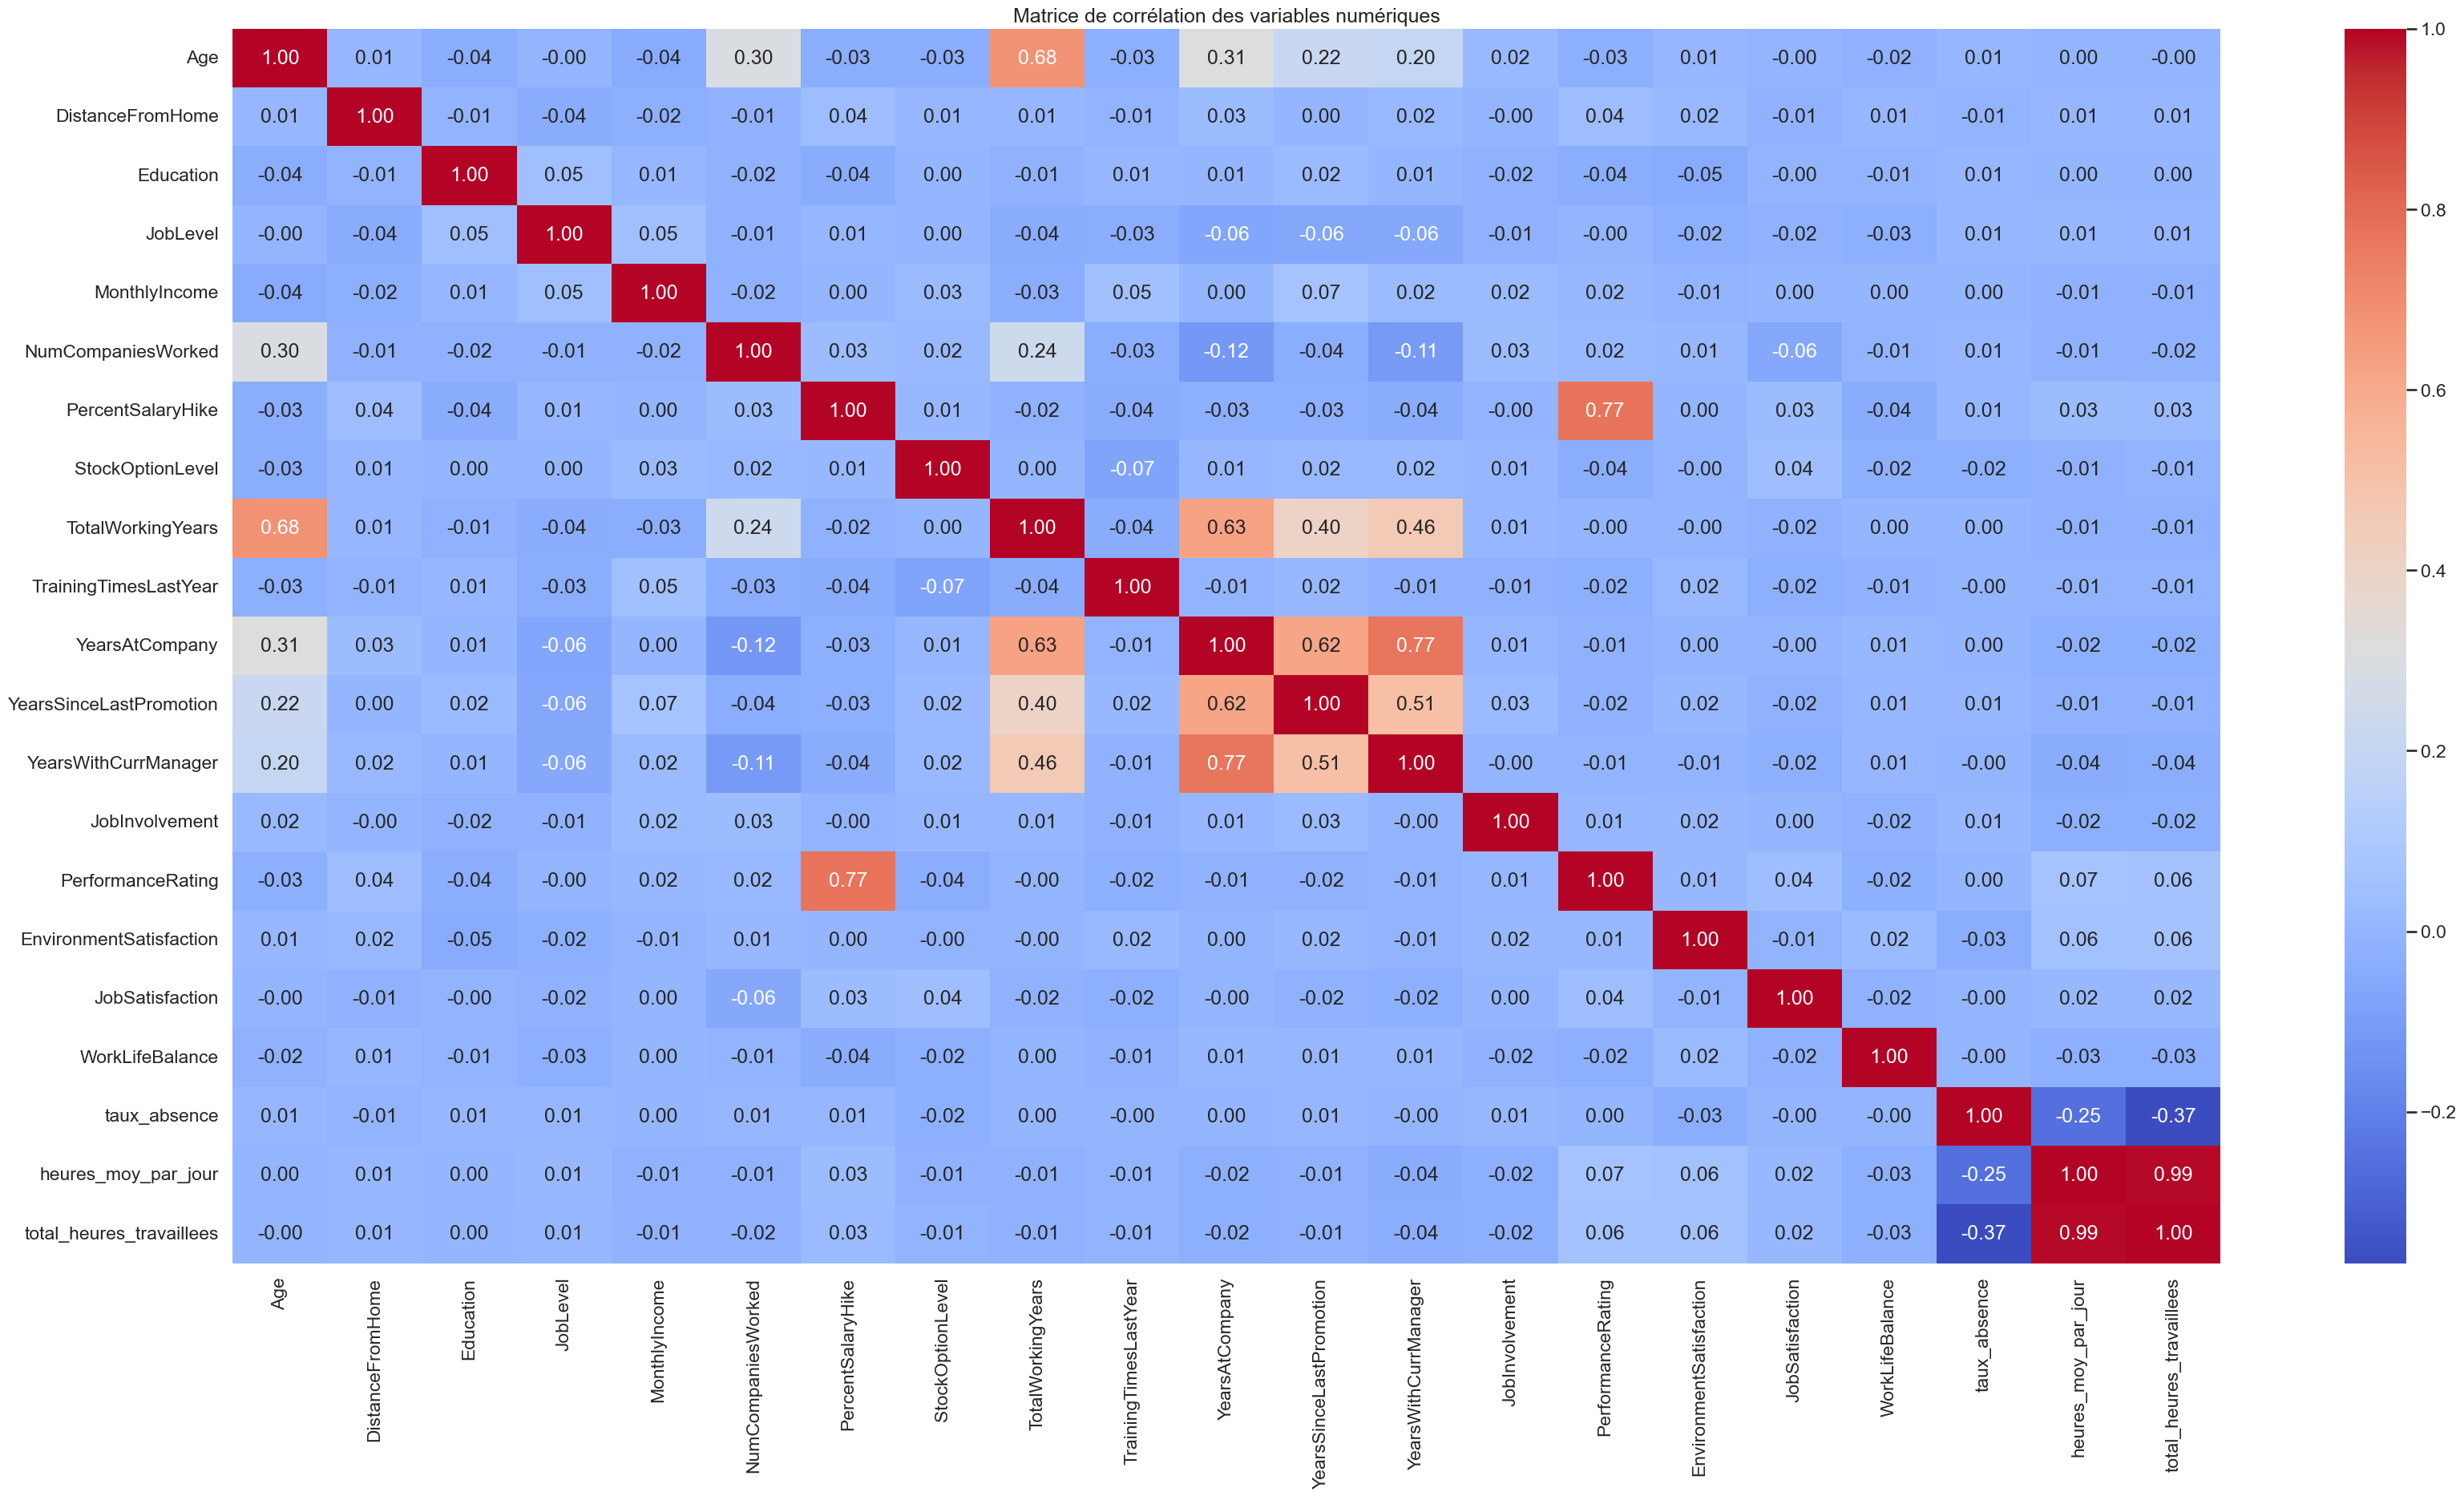

In [340]:
corr_matrix = num_scaled.corr()

plt.figure(figsize=(40, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation des variables numériques")
plt.show()

### Visualisatin des relations entre les Variables

### Analyse de la Variables Cible

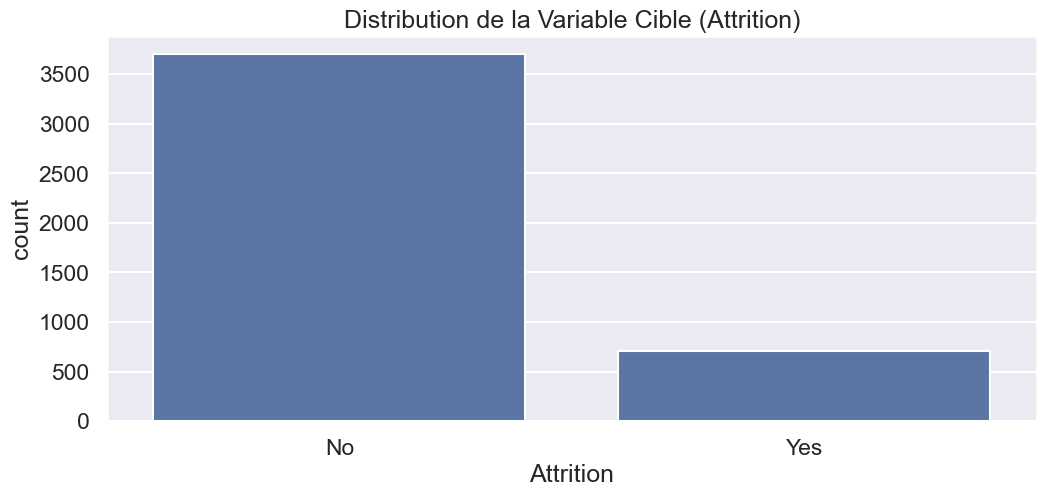

In [341]:
sns.countplot(x='Attrition', data=merged_df)
plt.title('Distribution de la Variable Cible (Attrition)')
plt.show()

### Relation entre les variables et la cible

## Application des modèles

### Préparation des données d'apprentissage et de test

In [342]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train = y_train.replace({'Yes': 1, 'No': 0})
y_test = y_test.replace({'Yes': 1, 'No': 0})

### Régression Logistique

Matrice de Confusion (Régression Logistique) : 
 [[1077   38]
 [ 151   57]]
Rapport de classification (Régression Logistique) :
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1115
           1       0.60      0.27      0.38       208

    accuracy                           0.86      1323
   macro avg       0.74      0.62      0.65      1323
weighted avg       0.83      0.86      0.83      1323

AUC-ROC (Régression Logistique) :
 0.6199788720248363


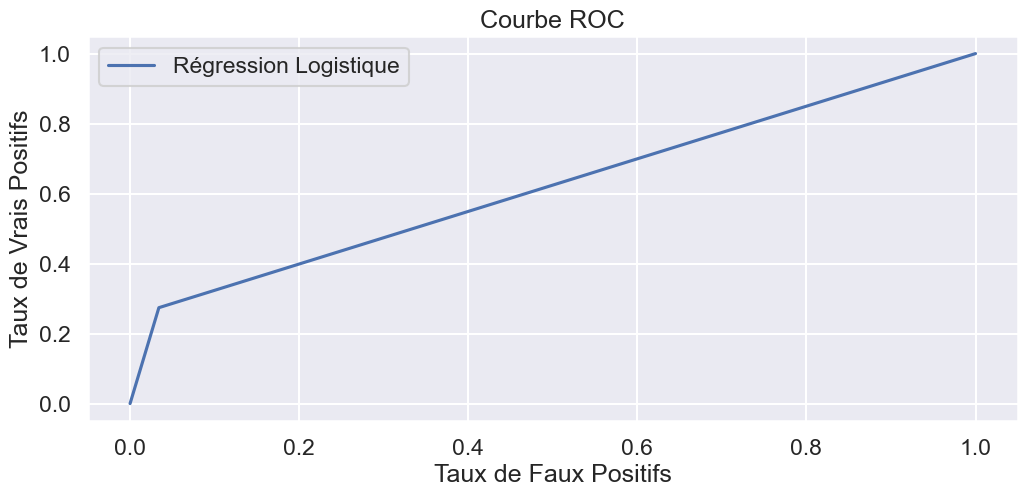

In [343]:
# Initialisation et entraînement du modèle
log_reg = LogisticRegression(max_iter=1000, random_state=42) # Initialisation
log_reg.fit(X_train, y_train)  # Entrainement

#Prédictions
y_pred_log_reg = log_reg.predict(X_test)

# Matrice de confusion 
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
print("Matrice de Confusion (Régression Logistique) : \n", conf_matrix_log_reg)

# Rapport de classification
class_report_log_reg = classification_report(y_test, y_pred_log_reg)
print("Rapport de classification (Régression Logistique) :\n", class_report_log_reg)

# AUC-ROC
roc_auc_log_reg = roc_auc_score(y_test, y_pred_log_reg)
print("AUC-ROC (Régression Logistique) :\n", roc_auc_log_reg)

#Courbe ROC
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_log_reg)
plt.plot(fpr_log_reg, tpr_log_reg, label="Régression Logistique")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

### Perceptron

Matrice de Confusion (Perceptron) : 
 [[976 139]
 [103 105]]
Rapport de classification (Perceptron) :
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      1115
           1       0.43      0.50      0.46       208

    accuracy                           0.82      1323
   macro avg       0.67      0.69      0.68      1323
weighted avg       0.83      0.82      0.82      1323

AUC-ROC (Perceptron) :
 0.6900720075888236


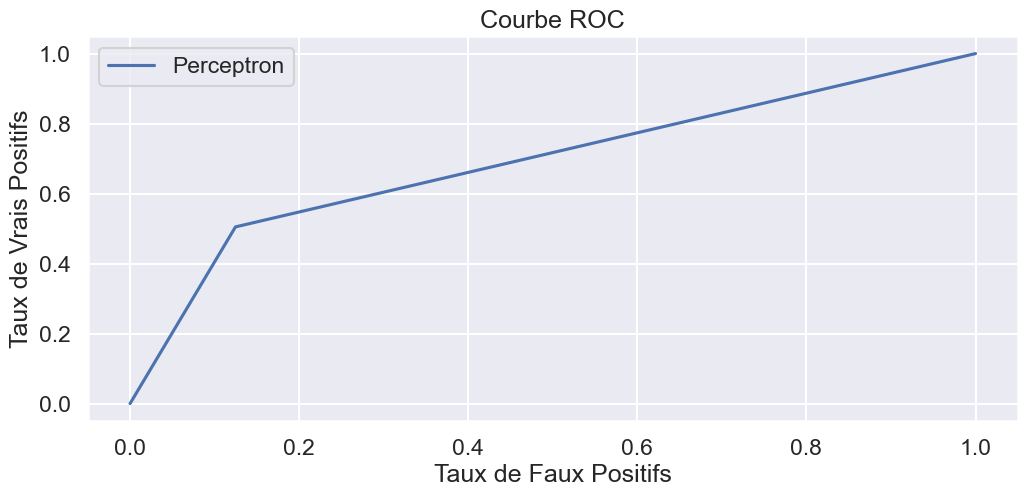

In [344]:
# Initialisation et entraînement du modèle
perceptron = Perceptron() # Initialisation
perceptron.fit(X_train, y_train)  # Entrainement

#Prédictions
y_pred_perceptron = perceptron.predict(X_test)

# Matrice de confusion 
conf_matrix_perceptron = confusion_matrix(y_test, y_pred_perceptron)
print("Matrice de Confusion (Perceptron) : \n", conf_matrix_perceptron)

# Rapport de classification
class_report_perceptron = classification_report(y_test, y_pred_perceptron)
print("Rapport de classification (Perceptron) :\n", class_report_perceptron)

# AUC-ROC
roc_auc_perceptron = roc_auc_score(y_test, y_pred_perceptron)
print("AUC-ROC (Perceptron) :\n", roc_auc_perceptron)

#Courbe ROC
fpr_perceptron, tpr_perceptron, thresholds_perceptron = roc_curve(y_test, y_pred_perceptron)
plt.plot(fpr_perceptron, tpr_perceptron, label="Perceptron")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

### Naive Bayes

Matrice de Confusion (Naive Bayes) : 
 [[961 154]
 [111  97]]
Rapport de classification (Naive Bayes) :
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      1115
           1       0.39      0.47      0.42       208

    accuracy                           0.80      1323
   macro avg       0.64      0.66      0.65      1323
weighted avg       0.82      0.80      0.81      1323

AUC-ROC (Naive Bayes) :
 0.6641147809589514


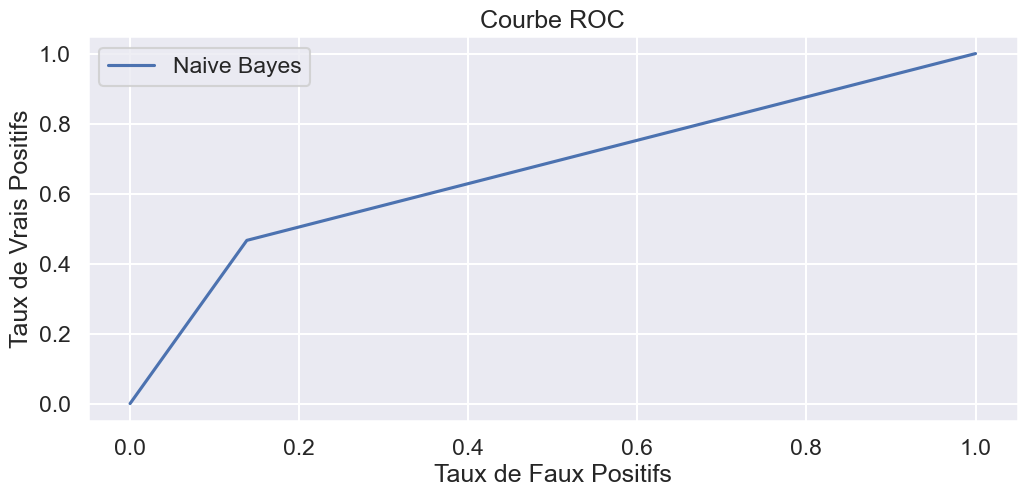

In [345]:
# Initialisation et entraînement du modèle
nb_model = GaussianNB() # Initialisation
nb_model.fit(X_train, y_train)  # Entrainement

#Prédictions
y_pred_nb_model = nb_model.predict(X_test)

# Matrice de confusion 
conf_matrix_nb_model = confusion_matrix(y_test, y_pred_nb_model)
print("Matrice de Confusion (Naive Bayes) : \n", conf_matrix_nb_model)

# Rapport de classification
class_report_nb_model = classification_report(y_test, y_pred_nb_model)
print("Rapport de classification (Naive Bayes) :\n", class_report_nb_model)

# AUC-ROC
roc_auc_nb_model = roc_auc_score(y_test, y_pred_nb_model)
print("AUC-ROC (Naive Bayes) :\n", roc_auc_nb_model)

#Courbe ROC
fpr_nb_model, tpr_nb_model, thresholds_nb_model = roc_curve(y_test, y_pred_nb_model)
plt.plot(fpr_nb_model, tpr_nb_model, label="Naive Bayes")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

### Random Forest

Matrice de Confusion (Random Forest) : 
 [[1113    2]
 [  29  179]]
Rapport de classification (Random Forest) :
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1115
           1       0.99      0.86      0.92       208

    accuracy                           0.98      1323
   macro avg       0.98      0.93      0.95      1323
weighted avg       0.98      0.98      0.98      1323

AUC-ROC (Random Forest) :
 0.9293916005519145


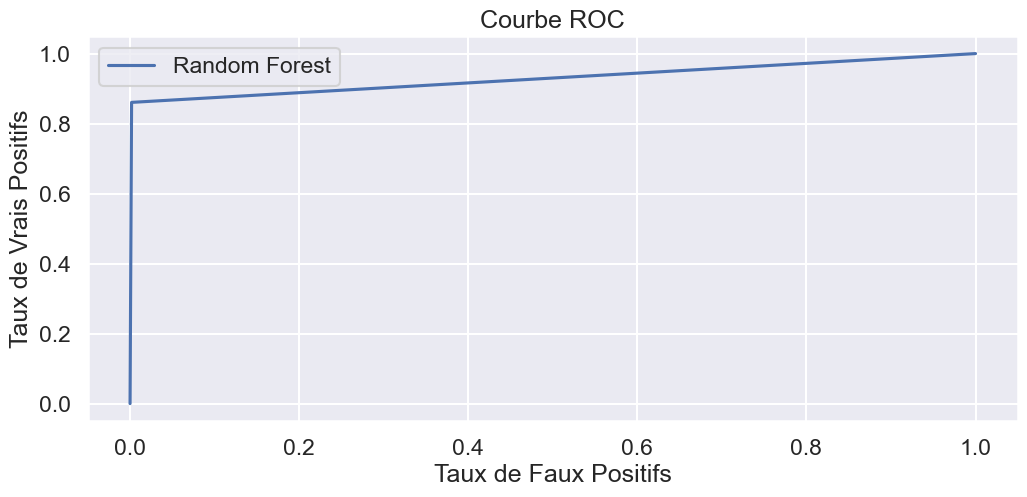

In [346]:
# Initialisation et entraînement du modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42) # Initialisation
rf_model.fit(X_train, y_train)  # Entrainement

#Prédictions
y_pred_rf_model = rf_model.predict(X_test)

# Matrice de confusion 
conf_matrix_rf_model = confusion_matrix(y_test, y_pred_rf_model)
print("Matrice de Confusion (Random Forest) : \n", conf_matrix_rf_model)

# Rapport de classification
class_report_rf_model = classification_report(y_test, y_pred_rf_model)
print("Rapport de classification (Random Forest) :\n", class_report_rf_model)

# AUC-ROC
roc_auc_rf_model = roc_auc_score(y_test, y_pred_rf_model)
print("AUC-ROC (Random Forest) :\n", roc_auc_rf_model)

#Courbe ROC
fpr_rf_model, tpr_rf_model, thresholds_rf_model = roc_curve(y_test, y_pred_rf_model)
plt.plot(fpr_rf_model, tpr_rf_model, label="Random Forest")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

# Comparaison et Choix des models

### Entrainement et prédictions

#### Matrice de confusion et Principales Métriques

In [347]:
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = {
    "Perceptron": Perceptron(),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "NaiveBayes": GaussianNB(),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Entraînement et prédiction
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

#Fonction pour afficher les résultats
def display_metrics(y_test, y_pred, model_name):
      print("Modèle :", model_name)
      print("Matrice de Confusion :\n", confusion_matrix(y_test, y_pred))
      print("Rapport de Classification :\n", classification_report(y_test, y_pred))

#Calcul des métriques
for name, y_pred in predictions.items():
    display_metrics(y_test, y_pred, name)
    print("\n")




Modèle : Perceptron
Matrice de Confusion :
 [[976 139]
 [103 105]]
Rapport de Classification :
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      1115
           1       0.43      0.50      0.46       208

    accuracy                           0.82      1323
   macro avg       0.67      0.69      0.68      1323
weighted avg       0.83      0.82      0.82      1323



Modèle : LogisticRegression
Matrice de Confusion :
 [[1077   38]
 [ 151   57]]
Rapport de Classification :
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1115
           1       0.60      0.27      0.38       208

    accuracy                           0.86      1323
   macro avg       0.74      0.62      0.65      1323
weighted avg       0.83      0.86      0.83      1323



Modèle : NaiveBayes
Matrice de Confusion :
 [[961 154]
 [111  97]]
Rapport de Classification :
               precision    recall  f1-scor

### Affichage des Matrices de confusion de nos modèles

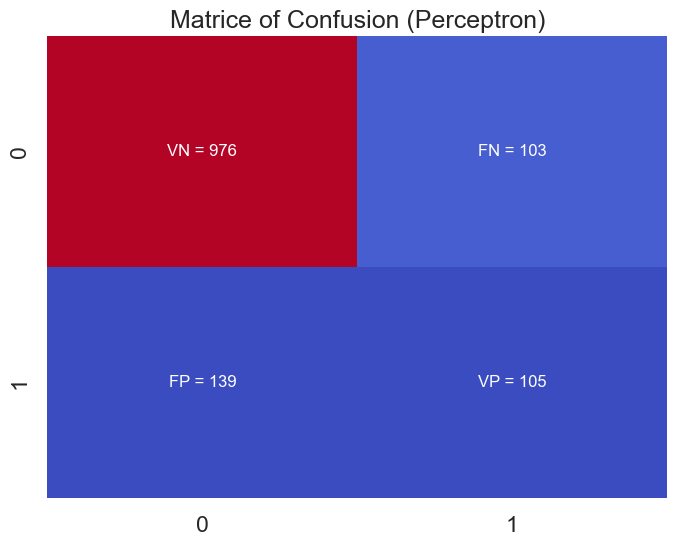

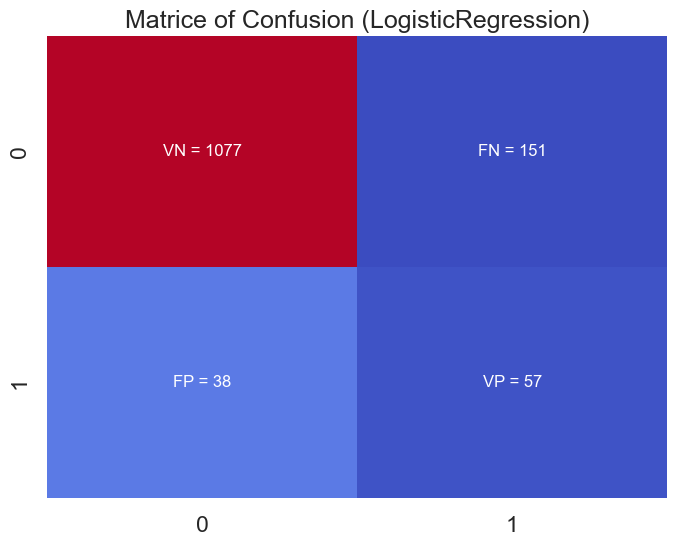

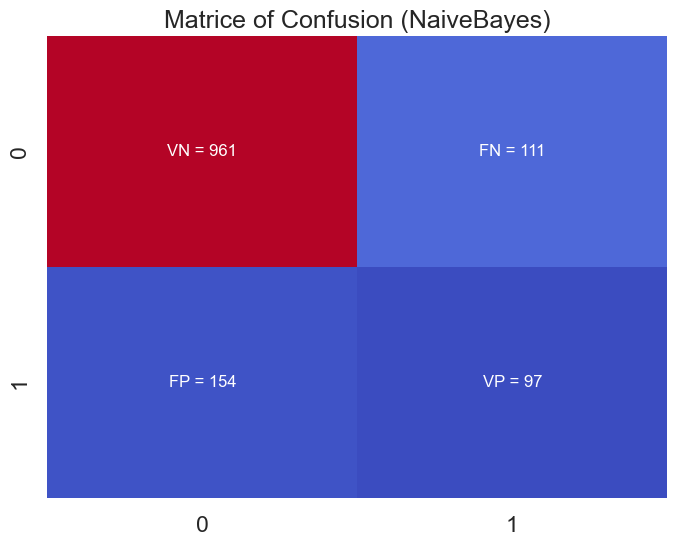

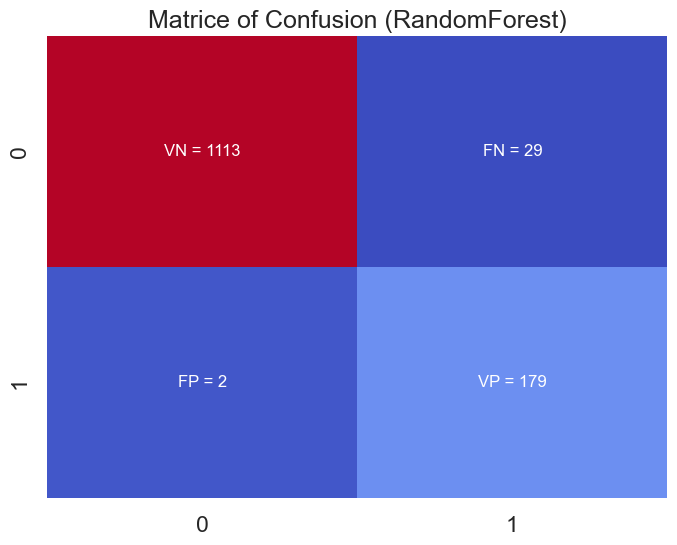

In [348]:
for name, y_pred in predictions.items():
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="coolwarm", cbar=False)
    VN, FP, FN, VP = conf_matrix.ravel()

    plt.text(0.5, 0.5, f'VN = {VN}', ha='center', va='center', color='white', fontsize=12)
    plt.text(0.5, 1.5, f'FP = {FP}', ha='center', va='center', color='white', fontsize=12)
    plt.text(1.5, 0.5, f'FN = {FN}', ha='center', va='center', color='white', fontsize=12)
    plt.text(1.5, 1.5, f'VP = {VP}', ha='center', va='center', color='white', fontsize=12)
    plt.title(f"Matrice of Confusion ({name})")
    plt.show()

# Afficharge des valeurs de Prédiction et de Recall ainsi que la courbe ROC

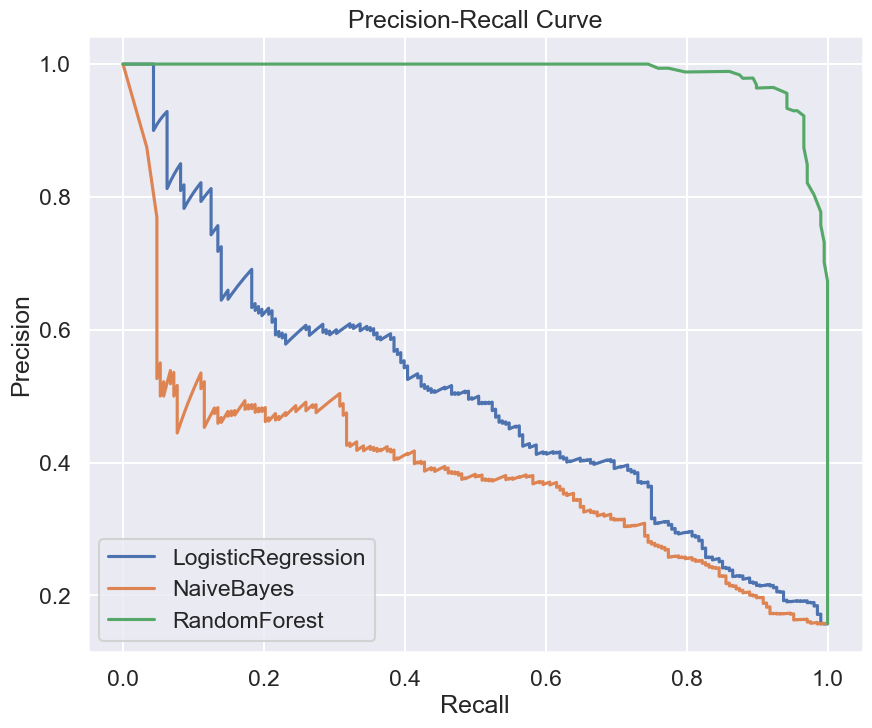

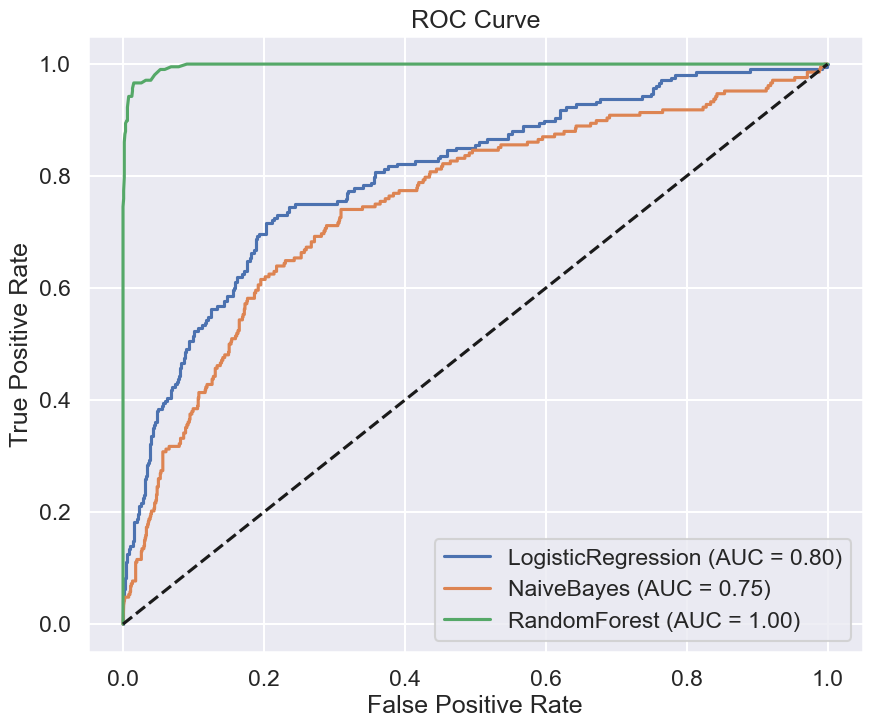

In [349]:
# Tracer les courbes de Précision-Rappel
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, label=f"{name}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# Calcul des statistiques pour la comparaison

### Affichage sous forme de boxplot

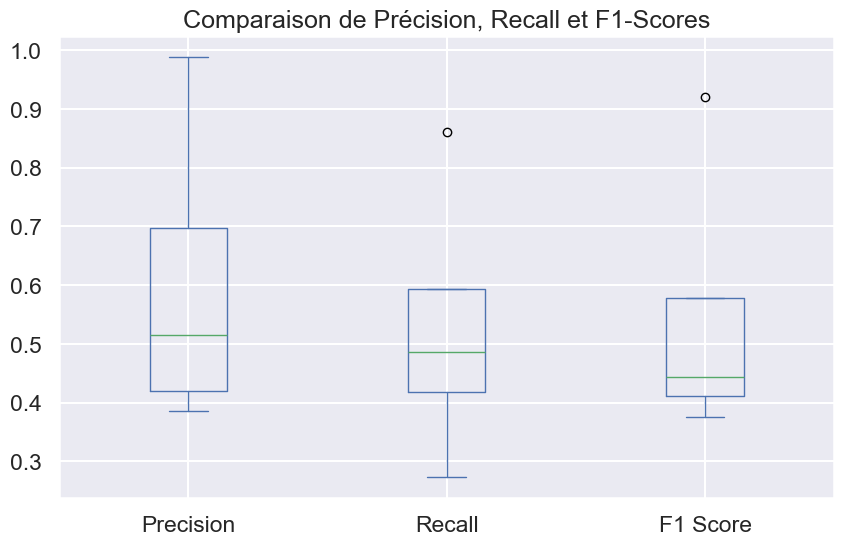

In [350]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_scores = []
recall_scores = []
f1_scores = []

for name, y_pred in predictions.items():
    precision_scores.append(
        precision_score(y_test, y_pred, pos_label=1)
    )
    recall_scores.append(
        recall_score(y_test, y_pred, pos_label=1)
    )
    f1_scores.append(
        f1_score(y_test, y_pred, pos_label=1)
    )

score_df = pd.DataFrame({
    'Model': models.keys(),
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

score_df.plot(kind='box', figsize=(10, 6))
plt.title("Comparaison de Précision, Recall et F1-Scores")
plt.show()


### Mettre sous forme de tableau

In [351]:
from sklearn.metrics import roc_auc_score

scores = []

for name, y_pred in predictions.items():
    y_proba = models[name].predict_proba(X_test)[:, 1] if hasattr(models[name], "predict_proba") else None
    auc_score = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    scores.append({
        'Model': name,
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': auc_score
    })

scores_df = pd.DataFrame(scores)
print(scores_df)


                Model  Precision  Recall  F1 Score  AUC
0          Perceptron       0.43    0.50      0.46  NaN
1  LogisticRegression       0.60    0.27      0.38 0.80
2          NaiveBayes       0.39    0.47      0.42 0.75
3        RandomForest       0.99    0.86      0.92 1.00


### Mesure du temps d'entraînement et de prédiction

In [352]:
import time

training_times = []
prediction_times = []

for name, model in models.items():
    # Temps d'entraînement
    start_time = time.time()
    model.fit(X_train, y_train)
    training_times.append(time.time() - start_time)

    # Temps de prédiction
    start_time = time.time()
    model.predict(X_test)
    prediction_times.append(time.time() - start_time)

time_df = pd.DataFrame({
    'Model': models.keys(),
    'Training Time (s)': training_times,
    'Prediction Time (s)': prediction_times
})

print(time_df)


                Model  Training Time (s)  Prediction Time (s)
0          Perceptron               0.01                 0.00
1  LogisticRegression               0.02                 0.00
2          NaiveBayes               0.00                 0.00
3        RandomForest               0.32                 0.01


# Interprétation des résultats

### Analyse des Performances 

### Discussion des Résultats

# Conclusion

### Synthèse des Tavaux Réalisés

### Perspectives d'amélioration

### Futurs travaux